In [1]:
from google.colab import files
uploaded = files.upload()

Saving cat_dog.jpg to cat_dog.jpg


In [5]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    #img_path = sys.argv[1]
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)
    #conv_output = [l for l in model.layers[0].layers if l.name is layer_name][0].output
    conv_output = [l for l in model.layers if l.name is layer_name][0].output
    #print(conv_output)

    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)
    
    cv2.imwrite("image.jpg", image)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

preprocessed_input = load_image('cat_dog.jpg')
#preprocessed_input = load_image("./examples/boat.jpg")



model = VGG16(weights='imagenet')

model.summary()

predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

print(predictions.shape)
topK = 20
decoded = decode_predictions(predictions, top=topK)[0]
#print('Predicted:', decoded)


predicted_class = 282
#predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam.jpg", cam)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

True

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'Grad-CAM for Cat')

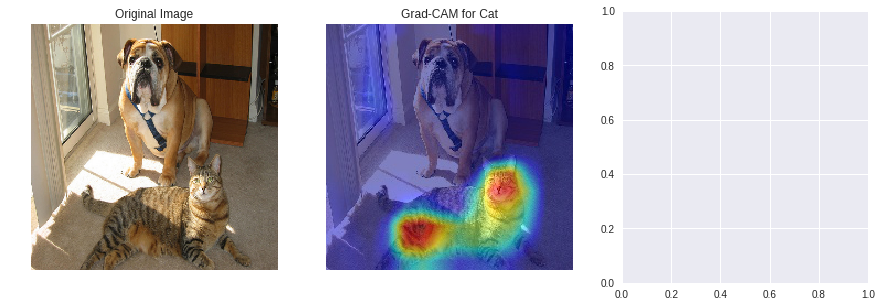

In [6]:
from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize
fig, axs = plt.subplots(1,3,figsize=(15,5))

img = io.imread('cat_dog.jpg')
image = resize(img, (224, 224))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')

img = io.imread('gradcam.jpg')
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Grad-CAM for Cat')


In [0]:
from google.colab import files
files.download('gradcam.jpg')
files.download('guided_gradcam.jpg')

In [0]:
from google.colab import files
files.download('image.jpg')

In [0]:
print(predictions.shape)
topK = 5
decoded = decode_predictions(predictions, top=topK)[0]
print('Predicted:', decoded)

(1, 1000)
Predicted: [('n02108422', 'bull_mastiff', 0.4094386), ('n02108089', 'boxer', 0.3950905), ('n02109047', 'Great_Dane', 0.039510123), ('n02109525', 'Saint_Bernard', 0.031701196), ('n02129604', 'tiger', 0.01916956)]


In [0]:
!pip install keras-vis

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


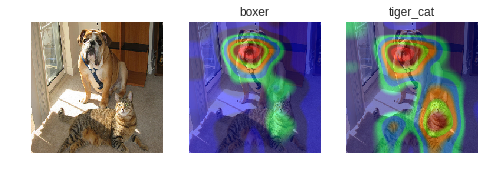

In [0]:
from vis.utils import utils
from vis.visualization import visualize_cam, overlay
from matplotlib import pyplot as plt
import matplotlib.cm as cm

topK_synsets = [triple[0] for triple in decoded]
topK_names = [triple[1] for triple in decoded]
topK_scores = [triple[2] for triple in decoded]

class_names = ['boxer', 'tiger_cat']
topK_ndx = []
imagenet_ndx = [] # indexes into the softmax entries of final layer
for i, name in enumerate(class_names):
    ndx = topK_names.index(name)
    topK_ndx.append(ndx)
    imagenet_ndx.append(np.argwhere(predictions[0] == topK_scores[ndx])[0][0])
# 282 = Tiger cat, 242 = Boxer (0 indexed)

img = utils.load_img('cat_dog.jpg', target_size=(224, 224))
N = len(class_names)
fig, ax = plt.subplots(1, N+1)
ax[0].imshow(img)
ax[0].axis('off')

# Lets overlay the heatmap for each desired class onto original image.    
for i in range(N):
    ndx = imagenet_ndx[i]
    layer_idx = utils.find_layer_idx(model, 'predictions') # final layer
    grads = visualize_cam(model, layer_idx, filter_indices=ndx, 
                        seed_input=img, backprop_modifier='guided') 
    #jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    jet_heatmap = np.uint8(cm.jet(grads) * 255)[:, : , :, 0]
    ax[i+1].imshow(overlay(jet_heatmap, img))
    ax[i+1].axis('off')
    ax[i+1].set_title(class_names[i])
plt.show()

In [0]:
ls

cat_dog.jpg  datalab/


In [0]:
files.download('gradcam.jpg')
files.download('guided_gradcam.jpg')

In [0]:
!rm -rf image.jpg

NameError: ignored

In [0]:
ls

cat_dog.jpg  datalab/  gradcam.jpg  guided_gradcam.jpg


In [0]:
preprocessed_input = load_image('cat_dog.jpg')
cv2.imwrite("image.jpg", preprocessed_input)

False

In [0]:
from google.colab import files
files.download('image.jpg')